# Sumário

[1. Normalizações](#1.-Normalizações)
- [1.1 Z-score normalization](#1.1-Z-score-normalization)
- [1.2 Min-max scaling](#1.2-Min-max-scaling)
- [1.3 Z-score vs Min-Max](#1.3-Z-score-vs-Min-Max)

[2. Prática](#2.-Prática)
- [2.1 Imports](#2.1-Imports)
- [2.2 Banco de Dados](#2.2-Banco-de-Dados)
- [2.3 Padronização e escalonamento](#2.3-Padronização-e-escalonamento)
- [2.4 Naive Bayes e PCA](#2.4-Naive-Bayes-e-PCA)
    - [2.4.1 Importando o Wine Dataset](#2.4.1-Importando-o-Wine-Dataset)
    - [2.4.2 Dividindo o banco em treinamento e teste](#2.4.2-Dividindo-o-banco-em-treinamento-e-teste)
    - [2.4.3 Padronização](#2.4.3-Padronização)
    - [2.4.4 Redução de dimensionalidade via PCA](#2.4.4-Redução-de-dimensionalidade-via-PCA)
    - [2.4.5 Treinando o classificador Naive-Bayes](#2.4.5-Treinando-o-classificador-Naive-Bayes)
    - [2.4.6 Avaliando a acurácia](#2.4.6-Avaliando-a-acurácia)
    
[Apêndice A: o efeito do escalonamento e centralização pela média para o PCA](#Apêndice-A:-o-efeito-do-escalonamento-e-centralização-pela-média-para-o-PCA)
- [1. Centralização pela média não afeta a matriz de covariância](#1.-Centralização-pela-média-não-afeta-a-matriz-de-covariância)
- [2. Escalonamento das variáveis afeta a matriz de covariância](#2.-Escalonamento-das-variáveis-afeta-a-matriz-de-covariância)
- [3. Padronização influencia a covariância](#3.-Padronização-influencia-a-covariância)

[Referências](#Referências)

# 1. Normalizações

## 1.1 Z-score normalization

O resultado da padronização (standardization) é que os atributos vão ser reescalados de tal forma que eles terão as **propriedades da distribuição normal**, ou seja, $\mu = 0$ e $\sigma = 1$. **O resultado da padronização é importante tanto para comparar medidas com unidades diferentes (altura em cm e pol, por exemplo) quanto é um requisito geral para muitos algoritmos de machine learning**.

A padronização é feita utilizando a seguinte fórmula:

$$Z = \frac{x - \mu}{\sigma}$$

sendo a média dada por:

$$\mu = \frac{1}{N}\sum_{i=1}^N{x_i}$$

e desvio-padrão:

$$\sigma = \sqrt{\frac{1}{N}\sum_{i=1}^N{(x_i - \mu)^2}}$$

Por exemplo, podemos citar o método do **gradiente descendente**, onde atributos em diferentes escalas ocasionarão em pesos que podem atualizar mais rápidos que outros. Também podemos citar o **kNN** e *algoritmos de clusterização* que usam, por exemplo, medidas de **distância Euclideana**. Provavelmente, classificadores baseados em árvores (como **árvores de decisão**) são os únicos classificadores que o escalonamento de características não faz diferença, uma vez que classificadores desse tipo fazem decisões do tipo "*se atributo x_i > algum_valor?*". Intuitivamente, podemos ver que realmente não importa em que escala os dados estão.

Exemplos de algoritmos em que o escalonamento de características importam:
- kNN com distância Euclideana se você quer que todos os atributos contribuam igualmente
- k-means
- Regressão Logística, SVMs, Perceptrons, Redes Neurais, etc. Se você utiliza qualquer método de otimização baseado em gradiente descendente/ascendente, caso contrário alguns pesos atualizarão mais rápidos que outros.
- LDA, PCA ou qualquer outro baseado em análise de componentes principais (ICA, por exemplo), desde que você quer encontrar as direções que maximizam a variância (sob as restrições que aquelas direções/autovetores/componentes principais são ortogonais);

Além disso também é importante pensar se queremos *padronizar* ou *normalizar* (escalar de [0-1], por exemplo) nossos dados. Alguns algoritmos assumem que nossos dados estão centrados em zero. Por exemplo, se inicializamos os pesos com valores 0 (ou pequenos valores aleatório centrados em zero) em um perceptron multicamadas simples com funções de ativação *tanh*, nós queremos atualizar os pesos igualmente.

Como regra: na dúvida, apenas padronize os dados.

## 1.2 Min-max scaling

Uma alternativa a abordagem de normalização z-score (ou padronização) é o chamado **escalonamento Min-Max**, també chamado de **normalização** - causa comum de ambiguidades).

Nessa abordagem, os dados são escalados em uma faixa fixa de valores, geralmente [0-1].

O custo de ter essa gama limitada de valores - ao contrário da padronização - é que os dados passarão a ter desvio-padrão menor, que podem suprimir o efeito de *outliers*.

O escalonamento Min-Max geralmente é feito de acordo com a seguinte equação:

$$X_{norm} = \frac{X - X_{min}}{X_{max} - X_{min}}$$

## 1.3 Z-score vs Min-Max

Então, **qual das duas é melhor?** *Depende da sua aplicação*.

Por exemplo, em **problemas de clusterização**, padronização é especialmente crucial para comparar similaridades entre atributos baseada em medidas de distância. Outro exemplo, é o **PCA**, onde em geral preferimos padronização ao invés do escalonamento Min-Max, uma vez que estamos interessados nos componentes que maximizam a variância (dependendo da questão e se o PCA calcula os componentes principais via a matriz de correlação ao invés da matriz de covariância).

No entanto, o escalonamento Min-Max também é bastante utilizado! Um exemplo é a o processamento de imagens, onde a intensidade dos pixels têm de ser normalizadas entre uma certa faixa de valores (em geral [0-255]). Além disso, alguns algoritmos de redes neurais também requerem dados entre [0-1].

# 2. Prática

Para verificamos o efeito da normalização dos dados, vamos utilizar o **Wine Dataset** e comparar a precisão de classificação utilizando o **classificador *Naive Bayes***. Além disso, também vamos aplicar o **PCA** para reduzir a dimensionalidade dos dados.

## 2.1 Imports

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn import metrics
from sklearn.model_selection import train_test_split
from sklearn.decomposition import PCA
from sklearn.naive_bayes import GaussianNB

%matplotlib inline

## 2.2 Banco de Dados

In [2]:
df = pd.io.parsers.read_csv(
    "https://raw.githubusercontent.com/rasbt/pattern_classification/master/data/wine_data.csv",
    header=None,
    usecols=[0, 1, 2],
)
df.columns = ["Class label", "Alcohol", "Malic acid"]
df.head()

,Class label,Alcohol,Malic acid
0,1,14.23,1.71
1,1,13.20,1.78
2,1,13.16,2.36
3,1,14.37,1.95
4,1,13.24,2.59


Como pode-se ver, os atributos *Alcohol* (percent/volume) e *Malic Acid* (g/l) estão em diferentes escalas. Logo, a normalização é necessariamente importante para comparar e combinar esses dados.

## 2.3 Padronização e escalonamento

In [3]:
std_scale = preprocessing.StandardScaler().fit(df[["Alcohol", "Malic acid"]])
df_std = std_scale.transform(df[["Alcohol", "Malic acid"]])

minmax_scale = preprocessing.MinMaxScaler().fit(df[["Alcohol", "Malic acid"]])
df_minmax = minmax_scale.transform(df[["Alcohol", "Malic acid"]])

print("Média após padronização:\nAlcohol={:.2f}, Malic acid={:.2f}".format(df_std[:, 0].mean(), df_std[:, 1].mean()))
print(
    "\nDesvio-padrão após padronização:\nAlcohol={:.2f}, Malic acid={:.2f}".format(
        df_std[:, 0].std(), df_std[:, 1].std()
    )
)

print()
print(
    "Menor valor após normalização:\nAlcohol={:.2f}, Malic acid={:.2f}".format(
        df_minmax[:, 0].min(), df_minmax[:, 1].min()
    )
)
print(
    "\nMaior valor após normalização:\nAlcohol={:.2f}, Malic acid={:.2f}".format(
        df_minmax[:, 0].max(), df_minmax[:, 1].max()
    )
)

Média após padronização:
Alcohol=-0.00, Malic acid=-0.00

Desvio-padrão após padronização:
Alcohol=1.00, Malic acid=1.00

Menor valor após normalização:
Alcohol=0.00, Malic acid=0.00

Maior valor após normalização:
Alcohol=1.00, Malic acid=1.00


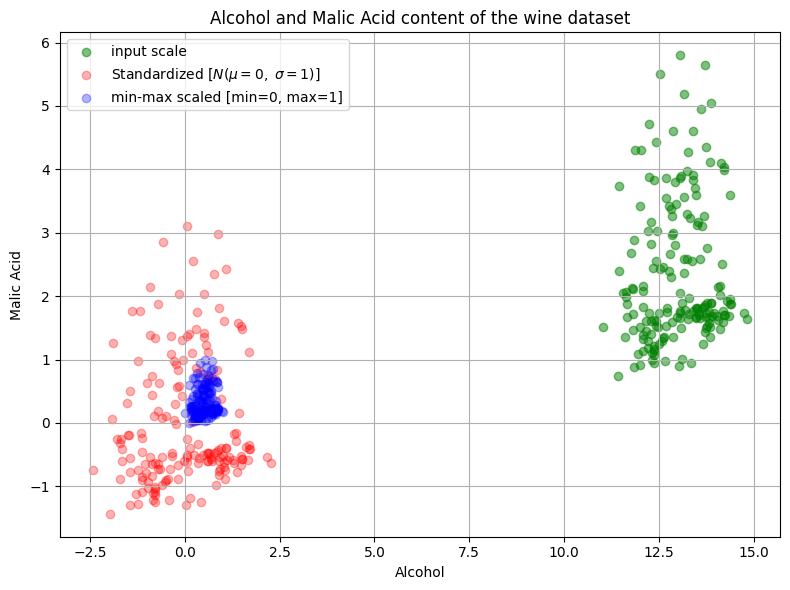

In [4]:
def plot():
    plt.figure(figsize=(8, 6))
    plt.scatter(df["Alcohol"], df["Malic acid"], color="green", label="input scale", alpha=0.5)
    plt.scatter(df_std[:, 0], df_std[:, 1], color="red", label="Standardized [$N  (\mu=0, \; \sigma=1)$]", alpha=0.3)
    plt.scatter(df_minmax[:, 0], df_minmax[:, 1], color="blue", label="min-max scaled [min=0, max=1]", alpha=0.3)
    plt.title("Alcohol and Malic Acid content of the wine dataset")
    plt.xlabel("Alcohol")
    plt.ylabel("Malic Acid")
    plt.legend(loc="upper left")
    plt.grid()
    plt.tight_layout()


plot()
plt.show()

O gráfico acima mostra todos os dados no mesmo gráfico. Agora, vamos dar um zoom em cada gráfico e mostrar cada dado em um gráfico diferente:

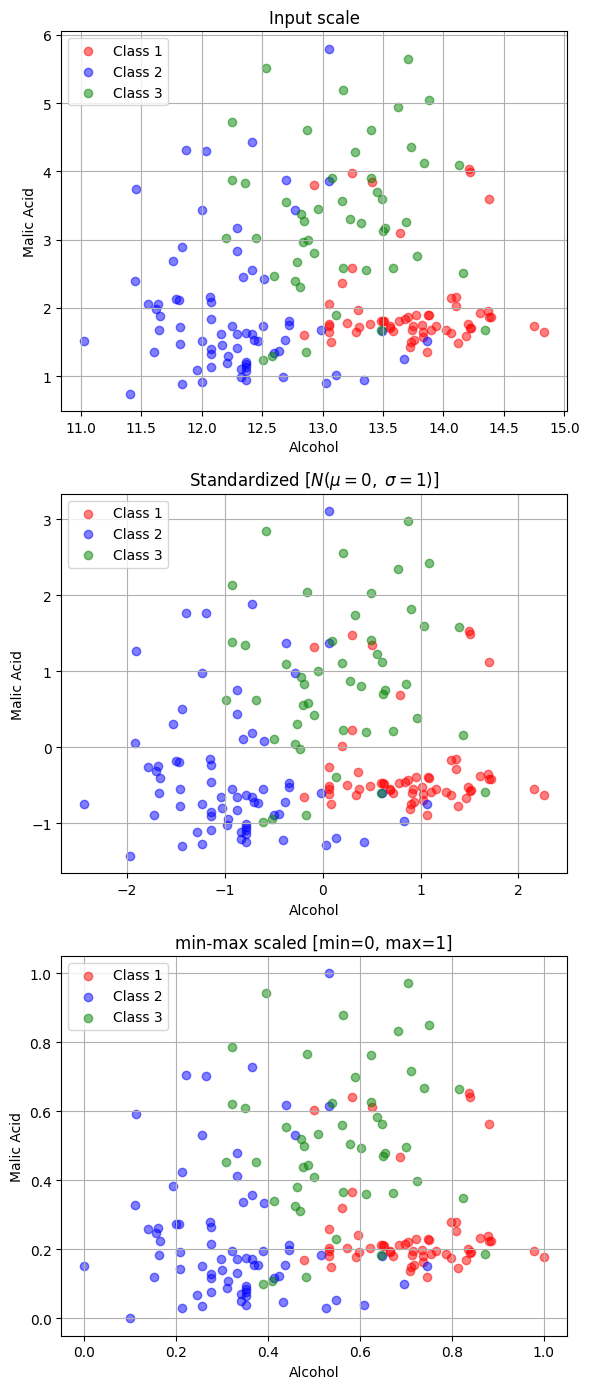

In [5]:
fig, ax = plt.subplots(3, figsize=(6, 14))
for a, d, title in zip(
    range(len(ax)),
    (df[["Alcohol", "Malic acid"]].values, df_std, df_minmax),
    ("Input scale", "Standardized [$N  (\mu=0, \; \sigma=1)$]", "min-max scaled [min=0, max=1]"),
):
    for i, c in zip(range(1, 4), ("red", "blue", "green")):
        ax[a].scatter(
            d[df["Class label"].values == i, 0],
            d[df["Class label"].values == i, 1],
            alpha=0.5,
            color=c,
            label="Class %s" % i,
        )
    ax[a].set_title(title)
    ax[a].set_xlabel("Alcohol")
    ax[a].set_ylabel("Malic Acid")
    ax[a].legend(loc="upper left")
    ax[a].grid()
plt.tight_layout()
plt.show()

## 2.4 Naive Bayes e PCA

Agora que vimos o efeito da padronização e escalonamento, vamos analisar o efeito da padronização no PCA em um problema de classificação de padrões.

Como vimos, a padronização é crucial para o PCA, uma vez que estamos *analisando* as variâncias de diferentes atributos. Agora, vamos ver como a padronização afeta o PCA seguida de uma classificação supervisionada no *Wine Dataset inteiro*.

Nas próximos seções, nós vamos:
- Ler o *Wine Dataset inteiro*;
- Dividí-lo em banco de treinamento e teste;
- Normalizar os atributos;
- Aplicar o **PCA** para reduzir a dimensionalidade;
- Treinar o **classificar Naive Bayes**; e 
- Avaliar a precisão da classificação com/sem normalização

### 2.4.1 Importando o Wine Dataset

In [6]:
import pandas as pd

url = "https://raw.githubusercontent.com/rasbt/pattern_classification/master/data/wine_data.csv"
df = pd.io.parsers.read_csv(url, header=None)
df.head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13
0,1,14.23,1.71,2.43,15.6,127,2.80,3.06,0.28,2.29,5.64,1.04,3.92,1065
1,1,13.20,1.78,2.14,11.2,100,2.65,2.76,0.26,1.28,4.38,1.05,3.40,1050
2,1,13.16,2.36,2.67,18.6,101,2.80,3.24,0.30,2.81,5.68,1.03,3.17,1185
3,1,14.37,1.95,2.50,16.8,113,3.85,3.49,0.24,2.18,7.80,0.86,3.45,1480
4,1,13.24,2.59,2.87,21.0,118,2.80,2.69,0.39,1.82,4.32,1.04,2.93,735


### 2.4.2 Dividindo o banco em treinamento e teste

Vamos dividir o Wine Dataset randomicamente em treinamento e teste, onde vamos utilizar 70% das amostras para treinamento e 30% para teste. Para isso, vamos tilizar o módulo *train_test_split* de *sklearn.cross_validation*.

In [7]:
X_wine = df.values[:, 1:]
y_wine = df.values[:, 0]
X_train, X_test, y_train, y_test = train_test_split(X_wine, y_wine, test_size=0.30, random_state=12345)

### 2.4.3 Padronização

In [8]:
std_scale = preprocessing.StandardScaler().fit(X_train)
X_train_std = std_scale.transform(X_train)
X_test_std = std_scale.transform(X_test)

min_max_scale = preprocessing.MinMaxScaler().fit(X_train)
X_train_minmax = min_max_scale.transform(X_train)
X_test_minmax = min_max_scale.transform(X_test)

### 2.4.4 Redução de dimensionalidade via PCA

Vamos reduzir os nossos dados 13-dimensional para um subespaço 2-dimensional e visualizar como nosso subespaço parece. É importante ressaltar que o PCA não utiliza os rótulos das classes, mas eu irei mostrar no gráfico para melhorar a visualização.

In [9]:
# nos dados não-padronizados
pca = PCA(n_components=2).fit(X_train)
X_train = pca.transform(X_train)
X_test = pca.transform(X_test)

# nos dados padronizados
pca_std = PCA(n_components=2).fit(X_train_std)
X_train_std = pca_std.transform(X_train_std)
X_test_std = pca_std.transform(X_test_std)

# nos dados escalonados
pca_minmax = PCA(n_components=2).fit(X_train_minmax)
X_train_minmax = pca_minmax.transform(X_train_minmax)
X_test_minmax = pca_minmax.transform(X_test_minmax)

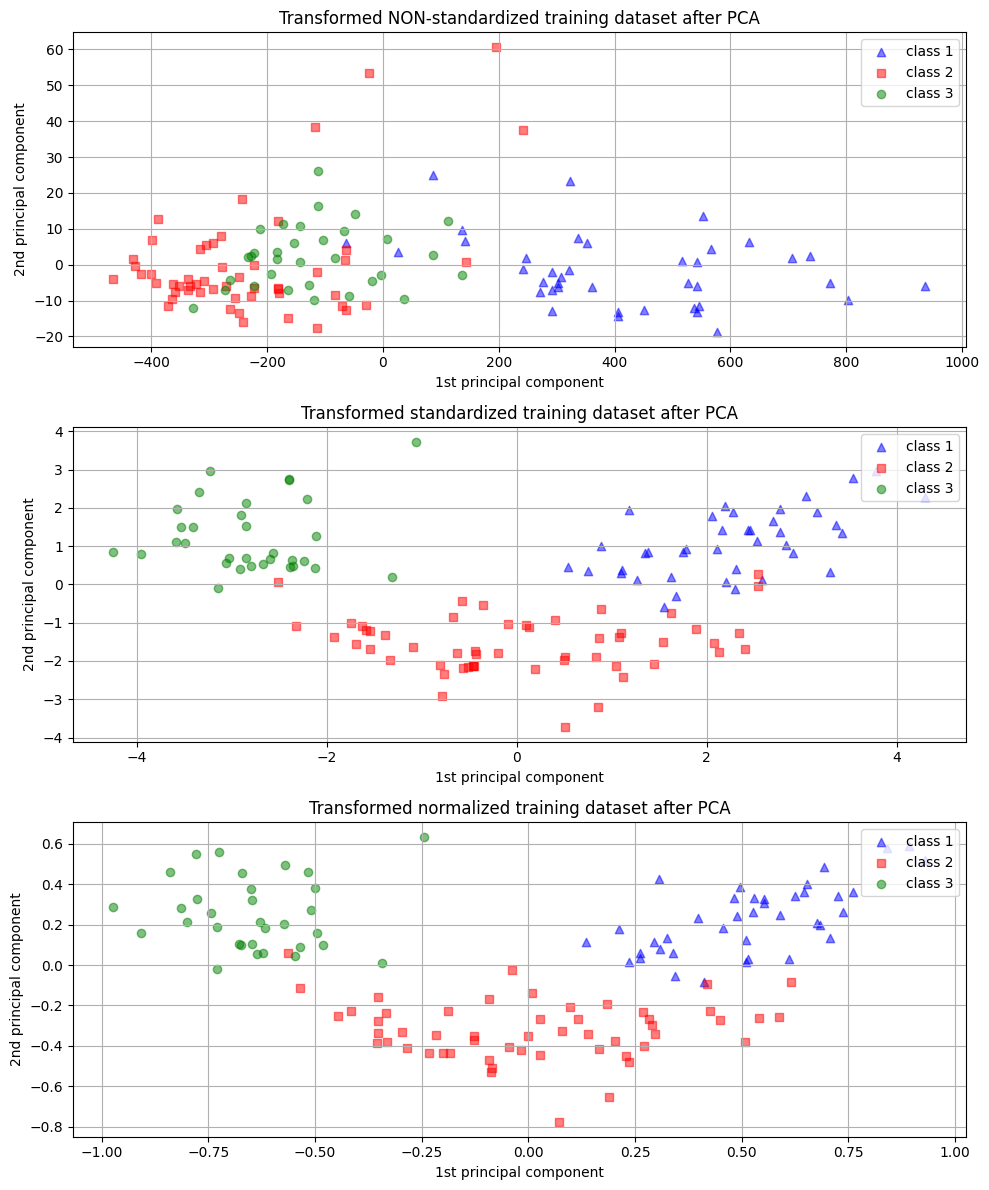

In [10]:
fig, (ax1, ax2, ax3) = plt.subplots(nrows=3, figsize=(10, 12))
for label, c, m in zip(range(1, 4), ("blue", "red", "green"), ("^", "s", "o")):
    ax1.scatter(
        X_train[y_train == label, 0],
        X_train[y_train == label, 1],
        color=c,
        label="class %s" % label,
        alpha=0.5,
        marker=m,
    )
for l, c, m in zip(range(1, 4), ("blue", "red", "green"), ("^", "s", "o")):
    ax2.scatter(
        X_train_std[y_train == l, 0], X_train_std[y_train == l, 1], color=c, label="class %s" % l, alpha=0.5, marker=m
    )
for l, c, m in zip(range(1, 4), ("blue", "red", "green"), ("^", "s", "o")):
    ax3.scatter(
        X_train_minmax[y_train == l, 0],
        X_train_minmax[y_train == l, 1],
        color=c,
        label="class %s" % l,
        alpha=0.5,
        marker=m,
    )
ax1.set_title("Transformed NON-standardized training dataset after PCA")
ax2.set_title("Transformed standardized training dataset after PCA")
ax3.set_title("Transformed normalized training dataset after PCA")
for ax in (ax1, ax2, ax3):
    ax.set_xlabel("1st principal component")
    ax.set_ylabel("2nd principal component")
    ax.legend(loc="upper right")
    ax.grid()
plt.tight_layout()
plt.show()

### 2.4.5 Treinando o classificador Naive-Bayes

Vamos utilizar o classificador Naive-Bayes para o nosso problema de classificação. O termo "*Naive*" (ingênuo) vem da suposição que todos os atributos são independentes.

O Naive-Bayes se baseia na **Regra de Bayes**:

$$P(\omega_j|x) = \frac{p(x|\omega_j)*P(\omega_j)}{p(x)}$$

onde:
- $\omega$: rótulo da classe
- $P(\omega|x)$: probabilidade posteriori
- $p(x|\omega)$: probabilidade a priori

e a regra de decisão:

$$Decida\ \omega_1\ se\ P(\omega_1|x) > P(\omega_2|x)\ senão\ decida\ \omega_2$$

$$\Rightarrow \frac{p(x|\omega_1)*P(\omega_1)}{p(x)} > \frac{p(x|\omega_2)*P(\omega_2)}{p(x)}$$

In [11]:
# nos dados não-padronizados
gnb = GaussianNB()
fit = gnb.fit(X_train, y_train)

# nos dados padronizados
gnb_std = GaussianNB()
fit_std = gnb_std.fit(X_train_std, y_train)

# nos dados normalizados
gnb_minmax = GaussianNB()
fit_minmax = gnb_minmax.fit(X_train_minmax, y_train)

### 2.4.6 Avaliando a acurácia

In [12]:
pred_train = gnb.predict(X_train)
print("\nAcurácia da predição para o banco de treinamento sem padronização")
print("{:.2%}".format(metrics.accuracy_score(y_train, pred_train)))

pred_test = gnb.predict(X_test)
print("\nAcurácia da predição para o banco de teste sem padronização")
print("{:.2%}\n".format(metrics.accuracy_score(y_test, pred_test)))


Acurácia da predição para o banco de treinamento sem padronização
81.45%

Acurácia da predição para o banco de teste sem padronização
64.81%



In [13]:
pred_train_std = gnb_std.predict(X_train_std)
print("\nAcurácia da predição para o banco de treinamento com padronização")
print("{:.2%}".format(metrics.accuracy_score(y_train, pred_train_std)))

pred_test_std = gnb_std.predict(X_test_std)
print("\nAcurácia da predição para o banco de treinamento com padronização")
print("{:.2%}\n".format(metrics.accuracy_score(y_test, pred_test_std)))


Acurácia da predição para o banco de treinamento com padronização
96.77%

Acurácia da predição para o banco de treinamento com padronização
98.15%



In [14]:
pred_train_minmax = gnb_minmax.predict(X_train_minmax)
print("\nAcurácia da predição para o banco de treinamento com normalizacao")
print("{:.2%}".format(metrics.accuracy_score(y_train, pred_train_minmax)))

pred_test_minmax = gnb_minmax.predict(X_test_minmax)
print("\nAcurácia da predição para o banco de treinamento com normalização")
print("{:.2%}\n".format(metrics.accuracy_score(y_test, pred_test_minmax)))


Acurácia da predição para o banco de treinamento com normalizacao
96.77%

Acurácia da predição para o banco de treinamento com normalização
100.00%



Como podemos observar, a escolha da padronização/normalização dos dados para o PCA definitivamente melhorou a acurácia do nosso modelo.

## Apêndice A: o efeito do escalonamento e centralização pela média para o PCA

Nessa sessão, vamos analisar se realmente importa ou não se as variáveis estão centralizadas para o PCA se o PCA é calculado a partir da matriz de covariância. Isto é, os n-principais componentes são os autovetores da matriz de covariância que correspondem aos n-maiores autovalores.

### 1. Centralização pela média não afeta a matriz de covariância

> **Independentemente se as variáveis foram centralizadas ou não, o resulto da covariância é o mesmo e consequentemente do PCA.**

Dado que temos 2 variáveis x e y, então a covariância é calculada como segue:

$$\sigma_{xy} = \frac{1}{n-1}\sum_i^n{(x_i - \overline{x})(y_i - \overline{y})}$$

Se considerarmos as variáveis centralizadas como:
$$x'= x-\overline{x}$$

$$y'= y-\overline{y}$$

a covariância, então, será calculada como:

$$\sigma'_{xy} = \frac{1}{n-1}\sum_i^n{(x'_i-\overline{x}')(y'_i-\overline{y}')}$$

Como a $\mu=0$ para as variáveis centralizadas, mesmo se centrarmos apenas uma variável, isso não afetaria a covariância:

$$\sigma_{xy} = \frac{1}{n-1}\sum_i^n{(x'_i-\overline{x}')(y_i-\overline{y})} = \frac{1}{n-1}\sum_i^n{(x'_i-0)(y_i-\overline{y})} = \frac{1}{n-1}\sum_i^n{(x_i-\overline{x})(y_i-\overline{y})}$$

### 2. Escalonamento das variáveis afeta a matriz de covariância

Se uma das variáveis está escalonada, por exemplo, de pounds para kilogramas (1 pound = 0.453592 kg), isso afeta a covariância e portanto influencia no resultado do PCA.

Dado *c* o fator de escala para x e sendo a variância calculada pela fórmula:

$$\sigma_{xy} = \frac{1}{n-1}\sum_i^n{(x_i - \overline{x})(y_i - \overline{y})}$$

a covariância após o escalonamento é calculada como:

$$\sigma'_{xy} = \frac{1}{n-1}\sum_i^n{(c.x_i-c.\overline{x})(y_i-\overline{y})} = \frac{c}{n-1}\sum_i^n{(x_i-\overline{x})(y_i-\overline{y})}$$

$$\Rightarrow \sigma'_{xy} = c.\sigma_{xy}$$

Logo, a matriz de covariância após o escalonamento de um atributo pela constante *c* vai resultar em uma covariância escalonada $c.\sigma_{xy}$. Logo, se escalonamos x de pounds para kg, a covariância entre x e y será 0,453592 vezes menor.

### 3. Padronização influencia a covariância

A padronização dos atributos terá um efeito no resultado do PCA (assumindo que as variáveis são originalmente não padronizadas). Isso acontece por que estamos escalando a covariância entre cada par de variáveis pelo produto do desvio-padrão de cada par de variáveis.

A equação da padronização pode ser escrita como:

$$Z = \frac{x_i - \overline{x}}{\sigma}$$

Sendo a matriz de covariância original:

$$\sigma_{xy} = \frac{1}{n-1}\sum_i^n{(x_i - \overline{x})(y_i - \overline{y})}$$

Após a padronização de ambas as variáveis:

$$x'= \frac{x - \overline{x}}{\sigma_x}\ ;\ y'= \frac{y - \overline{y}}{\sigma_y}$$

$$\sigma'_{xy} = \frac{1}{n-1}\sum_i^n{(x'_i - 0)(y'_i - 0)}$$

$$= \frac{1}{n-1}\sum_i^n\left(\frac{x-\overline{x}}{\sigma_x}\right)\left(\frac{y-\overline{y}}{\sigma_y}\right)$$

$$= \frac{1}{(n-1)\cdot\sigma_x\sigma_y}\sum_i^n(x-\overline{x})(y-\overline{y})$$

$$\Rightarrow \sigma'_{xy} = \frac{\sigma_{xy}}{\sigma_x\sigma_y}$$

# Referências

http://www.gladwinanalytics.com/blog/about-feature-scaling-and-normalization-and-the-effect-of-standardization-for-machine-learning-algorithms

Forina, M. et al, PARVUS - An Extendible Package for Data Exploration, Classification and Correlation. Institute of Pharmaceutical and Food Analysis and Technologies, Via Brigata Salerno, 16147 Genoa, Italy.

Bache, K. & Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.